In [1]:
# To add a new cell, type '# %%'
# To add a new markdown cell, type '# %% [markdown]'

# Debt Market Model

The purpose of this notebook is to configure and simulate the full CDP and APT system model, using the historical Ethereum price as a driver, under different PI controller settings - enabled, disabled, `kp` and `ki`.

# Setup and Dependencies

In [2]:
# Set project root folder, to enable importing project files from subdirectories
from pathlib import Path
import os

path = Path().resolve()
root_path = str(path).split('notebooks')[0]
os.chdir(root_path)

In [3]:
# Force reload of project modules, sometimes necessary for Jupyter kernel
%load_ext autoreload
%autoreload 2

In [4]:
# Display cadCAD version for easy debugging
%pip show cadCAD

Name: cadCAD
Version: 0.4.23
Summary: cadCAD: a differential games based simulation software package for research, validation, and         Computer Aided Design of economic systems
Home-page: https://github.com/cadCAD-org/cadCAD
Author: Joshua E. Jodesty
Author-email: joshua@block.science
License: LICENSE.txt
Location: /Users/zargham/opt/anaconda3/lib/python3.8/site-packages
Requires: fn, pandas, pathos, funcy
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [6]:
# Import all shared dependencies and setup
from shared import *

In [7]:
# Import notebook specific dependencies
import numpy as np
import datetime as dt
import pandas as pd
import pickle
import math
import ast

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# import plotly.io as pio
# pio.renderers.default = "png"

# Historical MakerDAO Dai debt market activity

In [8]:
# Import the historical MakerDAO market data CSV file
debt_market_df = pd.read_csv('models/market_model/data/debt_market_df.csv', index_col='date', parse_dates=True)
debt_market_df

,rho_star,beta,p,Q,v_1,v_2 + v_3,u_1,u_2 + u_3,u_2,w_2,u_3,w_3,w_2 + w_3,D_1,D_2,w_1,D,C_star,p_star,p_ema_10
date,,,,,,,,,,,,,,,,,,,,
2017-12-18,736.004090,0.005,1.017605,2.425662e+03,2526.662000,101.000000,5.953420e+05,4.594384e+01,1.000000e+01,0.000006,35.943840,0.000023,0.000029,5.952961e+05,0.000000e+00,0.000000,5.952961e+05,1.785297e+06,1,1.008573
2017-12-19,832.236972,0.005,1.003376,6.240431e+03,3821.320309,6.550995,1.379832e+06,3.539448e+04,3.536748e+04,0.455885,27.000000,0.000348,0.456233,1.939733e+06,2.604943e+01,26.505662,1.939759e+06,5.193518e+06,1,1.008573
2017-12-20,810.287507,0.005,1.012972,1.418307e+04,8066.895210,124.255903,2.676383e+06,5.022518e+05,5.014128e+05,0.178879,839.000000,0.000299,0.179179,4.113865e+06,8.208488e+01,56.214632,4.113947e+06,1.149236e+07,1,1.008573
2017-12-21,837.231080,0.005,1.025738,1.564473e+04,1471.742069,10.080000,8.053550e+05,4.978271e+04,4.978271e+04,1.158909,0.000000,0.000000,1.158909,4.869437e+06,1.474660e+02,66.539983,4.869584e+06,1.309826e+07,1,1.008573
2017-12-22,689.014990,0.005,0.972228,1.883084e+04,5316.960481,2130.848985,3.145512e+05,7.474531e+05,7.239153e+05,19.756468,23537.818000,0.642374,20.398842,4.436535e+06,1.876926e+02,60.625449,4.436723e+06,1.297473e+07,1,1.008573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-26,167.637314,0.125,1.021405,1.525944e+06,56696.770732,29566.578527,8.079170e+05,1.585480e+06,1.515115e+06,64257.311824,70364.380268,2984.212338,67241.524162,7.957442e+07,4.562428e+06,27167.708945,8.413685e+07,2.558052e+08,1,1.008076
2019-09-27,167.347085,0.125,1.007346,1.529959e+06,7598.158072,3582.812664,6.087607e+05,6.367461e+05,6.366783e+05,7214.430099,67.790257,0.768156,7215.198255,7.954644e+07,4.582358e+06,27145.743151,8.412880e+07,2.560342e+08,1,1.009903
2019-09-28,174.289775,0.125,1.011006,1.528450e+06,876.961579,2386.452089,2.251956e+05,1.452312e+05,1.452062e+05,492.589362,25.000000,0.084809,492.674170,7.962640e+07,4.609044e+06,27177.983765,8.423545e+07,2.663932e+08,1,1.011184


In [10]:
# Create a new column for `seconds_passed`, setting to 1 day in seconds - the sampling period available for historical data
debt_market_df.insert(0, 'seconds_passed', 24 * 3600)

ValueError: cannot insert seconds_passed, already exists

In [11]:
# Plot the full set of historical data over time
debt_market_df.plot()

In [12]:
debt_market_df[['u_1', 'u_2', 'v_1', 'v_2 + v_3']].plot()

In [14]:
debt_market_df[['u_1', 'u_2']].plot()

In [16]:
debt_market_df[['v_1', 'v_2 + v_3']].plot()

In [17]:
import seaborn as sns

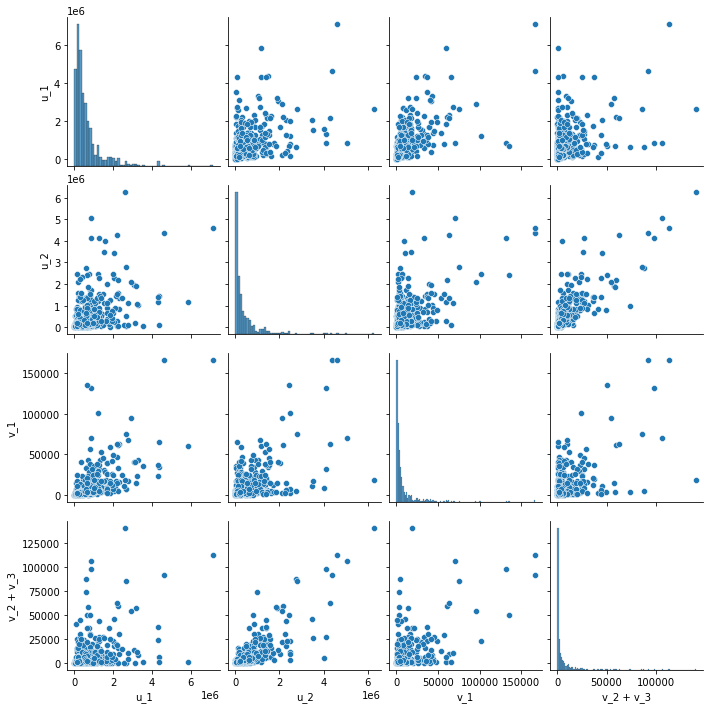

In [19]:
sns.pairplot(debt_market_df[['u_1', 'u_2', 'v_1', 'v_2 + v_3']])

In [75]:
debt_market_df['test_metric_draw'] =  debt_market_df.rho_star/debt_market_df.p*debt_market_df.v_1 /(debt_market_df.u_1)
debt_market_df['test_metric_draw'] = debt_market_df['test_metric_draw']*debt_market_df['u_1'].apply(lambda x: int(np.abs(x)>.0001))

In [74]:
debt_market_df['test_metric_draw'].hist()

In [65]:
debt_market_df['test_metric_wipe'] =  1/(debt_market_df.rho_star/debt_market_df.p*debt_market_df['v_2 + v_3'] /(debt_market_df.u_2))
debt_market_df['test_metric_wipe'] = debt_market_df['test_metric_wipe']*debt_market_df['v_2 + v_3'].apply(lambda x: int(np.abs(x)>.0001))

In [76]:
debt_market_df['test_metric_wipe'].hist()

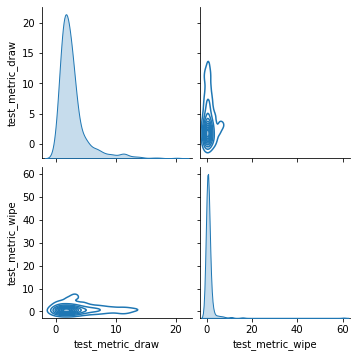

In [72]:
keys = ['test_metric_draw', 'test_metric_wipe']

sns.pairplot(debt_market_df[keys], dropna=True, kind='kde')


# APT Model Setup

In [10]:
# The full feature vector available for the APT model
features = ['beta', 'Q', 'v_1', 'v_2 + v_3', 
                    'D_1', 'u_1', 'u_2', 'u_3', 'u_2 + u_3', 
                    'D_2', 'w_1', 'w_2', 'w_3', 'w_2 + w_3',
                    'D']

# The feature vector subset used for the APT ML model
features_ml = ['beta', 'Q', 'v_1', 'v_2 + v_3', 'u_1', 'u_2', 'u_3', 'w_1', 'w_2', 'w_3', 'D']

# The unobservable events, or optimal values, returned from the root-finding algorithm
optvars = ['u_1', 'u_2', 'v_1', 'v_2 + v_3']

## Root-finding function

Load the APT model from a Pickle file, and configure the root-finding algorithm to be optimized using Scipy's `minimize` function and Powell's method.

In [11]:
# NB: Pickle files must be downloaded seperately and copied into `models/pickes/` directory
model = pickle.load(open('models/pickles/apt_debt_model_2020-11-28.pickle', 'rb'))

ml_data_list = []
global tol
tol = 1e-2
global curr_error, best_error, best_val
global strikes
strikes = 0
best_error = 1e10

def glf_continue_callback(xopt):
    print('entered callback')
    global curr_error, best_error, best_val, strikes, tol
    if curr_error > tol: # keep searching
        print('bigger than tol, keep searching')
        return False
    else:
        if curr_error > best_error: # add strike
            strikes += 1
            if strikes < 3: # continue trying
                print('bigger than prev best, add strike')
                return False
            else: # move on, not working
                strikes = 0
                print('3rd strike, stop')
                return True
        else: # better outcome, continue
            best_error = curr_error
            best_val = xopt
            strikes = 0
            print('New best, reset strikes')
            return False

# Global minimizer function
def glf(x, to_opt, data, constant, timestep):
    global curr_error
    for i,y in enumerate(x):
        data[:,to_opt[i]] = y
    err = model.predict(data)[0] - constant
    curr_error = abs(err)

    return curr_error

# Model Configuration

In [12]:
# Select the start date from historical data to use as the model initial state

# Select the start date, chosen for a gradually rising ETH price, and reasonable pool of CDP collateral and debt
start_date = '2018-04-01' # Rising ETH price

# Build a feature vector from the historical dataset at the start_date, to be used as the model initial state
historical_initial_state = {k: debt_market_df.loc[start_date][k] for k in features}
historical_initial_state

{'beta': 0.005,
 'Q': 130417.5685990905,
 'v_1': 3575.828421456681,
 'v_2 + v_3': 75.28608947093743,
 'D_1': 19377432.0069828,
 'u_1': 397538.45749999577,
 'u_2': 33461.767846354865,
 'u_3': 233.40479179693645,
 'u_2 + u_3': 33695.172638151795,
 'D_2': 9035.78589335348,
 'w_1': 264.9046197045797,
 'w_2': 6.757067083587955,
 'w_3': 0.04713235245204128,
 'w_2 + w_3': 6.8041994360399976,
 'D': 19386467.79287615}

In [13]:
# Pre-process the historical data

# Create a dataframe for the ETH price
eth_price_df = pd.DataFrame(debt_market_df['rho_star'])
# Calculate the mean ETH price
eth_price_mean = np.mean(eth_price_df.to_numpy().flatten())

# Create a dataframe for the market price
market_price_df = pd.DataFrame(debt_market_df['p'])
# Calculate the mean market price
market_price_mean = np.mean(market_price_df.to_numpy().flatten())

# Calculate the ETH returns and gross returns, for the equation to find the root of non-arbitrage condition
eth_returns = ((eth_price_df - eth_price_df.shift(1)) / eth_price_df.shift(1)).to_numpy().flatten()
eth_gross_returns = (eth_price_df / eth_price_df.shift(1)).to_numpy().flatten()

# Calculate the mean ETH returns
eth_returns_mean = np.mean(eth_returns[1:])

eth_price_mean, eth_returns_mean, market_price_mean

(365.8127290676168, -0.0012148823654996293, 1.0004125645956772)

In [14]:
# Set the initial ETH price state
eth_price = eth_price_df.loc[start_date][0]
# Set the initial market price state
market_price = debt_market_df.loc[start_date]['p']
# Set the initial target price, in Dollars
target_price = 1.0

# Configure the liquidation ratio parameter
liquidation_ratio = 1.5 # 150%
# Configure the liquidation buffer parameter: the multiplier for the liquidation ratio, that users apply as a buffer
liquidation_buffer = 2.0

# Configure the initial stability fee parameter, as a scaled version of the historical data beta at the start date
stability_fee = (historical_initial_state['beta'] * 30 / 365) / (30 * 24 * 3600)

In [15]:
# Decompose the debt market collateral initial states
eth_collateral = historical_initial_state['Q']
eth_locked = debt_market_df.loc[:start_date]['v_1'].sum()
eth_freed = debt_market_df.loc[:start_date]['v_2 + v_3'].sum() / 2
eth_bitten = debt_market_df.loc[:start_date]['v_2 + v_3'].sum() / 2

print(f'''
{eth_collateral}
{eth_locked}
{eth_freed}
{eth_bitten}
''')

# Check that the relationships between ETH locked, freed, and bitten are conserved
assert math.isclose(eth_collateral, eth_locked - eth_freed - eth_bitten, abs_tol=1e-6)

# Decompose the debt market principal debt initial states
principal_debt = historical_initial_state['D_1']
rai_drawn = debt_market_df.loc[:start_date]['u_1'].sum()
rai_wiped = debt_market_df.loc[:start_date]['u_2'].sum()
rai_bitten = debt_market_df.loc[:start_date]['u_3'].sum()

print(f'''
{principal_debt}
{rai_drawn}
{rai_wiped}
{rai_bitten}
''')

# Check that the relationships between debt drawn, wiped, and bitten are conserved
assert math.isclose(principal_debt, rai_drawn - rai_wiped - rai_bitten, abs_tol=1e-6)

# Calculate and print the initial collateralization ratio (should be approx. 3)
print(f'Collateralization ratio: {eth_collateral * eth_price / principal_debt * target_price}')


130417.5685990905
189872.3149593018
29727.37318010564
29727.37318010564


19377432.0069828
42320205.44783997
16068921.349645888
6873852.091211276

Collateralization ratio: 2.583272198102856


In [16]:
# Based on CDP collateral statistics, calculate the total number of initial CDPs to be created
median_cdp_collateral = 2500 # dollars
mean_cdp_collateral = 50 # dollars
genesis_cdp_count = int(eth_collateral / mean_cdp_collateral)
genesis_cdp_count

2608

In [17]:
# Create a pool of initial CDPs
cdp_list = []
for i in range(genesis_cdp_count):
    cdp_list.append({
        'open': 1, # Is the CDP open or closed? True/False == 1/0 for integer/float series
        'time': 0, # How long the CDP has been open for
        # Divide the initial state of ETH collateral and principal debt among the initial CDPs
        'locked': eth_collateral / genesis_cdp_count,
        'drawn': principal_debt / genesis_cdp_count,
        'wiped': 0.0, # Principal debt wiped
        'freed': 0.0, # ETH collateral freed
        'w_wiped': 0.0, # Accrued interest wiped
        'v_bitten': 0.0, # ETH collateral bitten (liquidated)
        'u_bitten': 0.0, # Principal debt bitten
        'w_bitten': 0.0, # Accrued interest bitten
        'dripped': 0.0 # Total interest accrued
    })

cdps = pd.DataFrame(cdp_list)
cdps

,open,time,locked,drawn,wiped,freed,w_wiped,v_bitten,u_bitten,w_bitten,dripped
0,1,0,50.006736,7429.996935,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,50.006736,7429.996935,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,50.006736,7429.996935,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,50.006736,7429.996935,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0,50.006736,7429.996935,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2603,1,0,50.006736,7429.996935,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2604,1,0,50.006736,7429.996935,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2605,1,0,50.006736,7429.996935,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2606,1,0,50.006736,7429.996935,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Initial State

In [18]:
initial_state = {
    'cdps': cdps, # A dataframe of CDPs (both open and closed)
    'timestamp': dt.datetime.strptime(start_date, '%Y-%m-%d'), # type: datetime; start time
    
    # Exogenous states
    'eth_price': eth_price, # unit: dollars; updated from historical data as exogenous parameter
    
    # CDP states
    # v - ETH collateral states
    'eth_collateral': eth_collateral, # "Q"; total ETH collateral in the CDP system i.e. locked - freed - bitten
    'eth_locked': eth_locked, # total ETH locked into CDPs; the cumulative sum of "v_1" activity
    'eth_freed': eth_freed, # total ETH freed from CDPs; the cumulative sum of "v_2" activity
    'eth_bitten': eth_bitten, # total ETH bitten/liquidated from CDPs; the cumulative sum of "v_3" activity
    'v_1': historical_initial_state['v_1'], # discrete "lock" event, in ETH
    'v_2': historical_initial_state['v_2 + v_3'] / 2, # discrete "free" event, in ETH
    'v_3': historical_initial_state['v_2 + v_3'] / 2, # discrete "bite" event, in ETH
    
    # u - principal debt states
    'principal_debt': principal_debt, # "D_1"; the total debt in the CDP system i.e. drawn - wiped - bitten
    'rai_drawn': rai_drawn, # total RAI debt minted from CDPs; the cumulative sum of "u_1" activity
    'rai_wiped': rai_wiped, # total RAI debt wiped/burned from CDPs in repayment; the cumulative sum of "u_2" activity
    'rai_bitten': rai_bitten, # total RAI liquidated from CDPs; the cumulative sum of "u_3" activity
    'u_1': historical_initial_state['u_1'], # discrete "draw" event, in RAI
    'u_2': historical_initial_state['u_2'], # discrete "wipe" event, in RAI
    'u_3': historical_initial_state['u_3'], # discrete "bite" event, in RAI
    
    # w - accrued interest states
    'accrued_interest': historical_initial_state['D_2'], # "D_2"; the total interest accrued in the system i.e. current D_2 + w_1 - w_2 - w_3
    'w_1': historical_initial_state['w_1'], # discrete "drip" event, in RAI
    'w_2': historical_initial_state['w_2'], # discrete "shut"/"wipe" event, in RAI
    'w_3': historical_initial_state['w_3'], # discrete "bite" event, in RAI
    
    # System states
    'stability_fee': stability_fee, # interest rate used to calculate the accrued interest; per second interest rate (1.5% per month)
    'market_price': market_price, # unit: dollars; the secondary market clearing price
    'target_price': target_price, # unit: dollars; equivalent to redemption price
    'target_rate': 0 / (30 * 24 * 3600), # per second interest rate (X% per month), updated by controller
    
    # APT model states
    'p_expected': target_price, # root of non-arbitrage condition
    'p_debt_expected': target_price, # predicted "debt" price, the intrinsic value of RAI according to the debt market activity and state
}

# Override initial state with historical initial state, for ML model starting condition
initial_state.update(historical_initial_state)

## Parameters

In [19]:
# Set dataframe to start from start date
debt_market_df = debt_market_df.loc[start_date:]

parameters = {
    # CDP parameters
    'new_cdp_collateral': [median_cdp_collateral], # The average CDP collateral for opening a CDP
    'liquidation_buffer': [liquidation_buffer], # multiplier applied to CDP collateral by users
    
    # System parameters
    'stability_fee': [lambda timestep, df=debt_market_df: stability_fee], # per second interest rate (x% per month)
    'liquidation_ratio': [liquidation_ratio], # e.g. 150%
    'liquidation_penalty': [0], # percentage added on top of collateral needed to liquidate CDP
    
    # Exogenous states, loaded as parameter at every timestep - these are lambda functions, and have to be called
    'eth_price': [lambda timestep, df=debt_market_df: df.iloc[timestep].rho_star],
    'seconds_passed': [lambda timestep, df=debt_market_df: df.iloc[timestep].seconds_passed],
    
    # APT model
    'root_function': [glf],
    'callback': [glf_continue_callback],
    'model': [model],
    'features': [features_ml],
    'optvars': [optvars],
    'bounds': [[(xmin,debt_market_df[optvars].max()[i]) 
        for i,xmin in enumerate(debt_market_df[optvars].min())
    ]],
    'eth_price_mean': [eth_price_mean],
    'eth_returns_mean': [eth_returns_mean],
    'market_price_mean': [market_price_mean],

    # Controller parameters
    'controller_enabled': [True],
    'kp': [5e-7], # proportional term for the stability controller: units 1/USD
    'ki': [lambda control_period=3600: -1e-7 / control_period], # integral term for the stability controller: units 1/(USD * seconds)
}

# Simulation Execution

In [20]:
# Set the number of simulation timesteps, with a maximum of `len(debt_market_df) - 1`
SIMULATION_TIMESTEPS = 100 # len(debt_market_df) - 1

In [21]:
# Create a wrapper for the model simulation, and update the existing parameters and initial state
system_simulation = ConfigWrapper(system_model_v2, T=range(SIMULATION_TIMESTEPS), M=parameters, initial_state=initial_state)

In [22]:
del configs[:] # Clear any prior configs
system_simulation.append() # Append the simulation config to the cadCAD `configs` list
(simulation_result, _tensor_field, _sessions) = run(drop_midsteps=False) # Run the simulation

INFO:root:Started simulation
DEBUG:root:p_expected terms: (1, 0.9964722501277672, 1.0, 3.86810578185312e-06, 365.8127290676168, 383.822378472222, 0.6756295152422528, 1.0004125645956772, 0, 0.9990556338569321)
DEBUG:root:
    ##### APT model run #####
    Timestep: 1
    
DEBUG:root:
    feature_0: [[5.00000000e-03 1.30417569e+05 3.57582842e+03 7.52860895e+01
  3.97538457e+05 3.34617678e+04 2.33404792e+02 2.64904620e+02
  6.75706708e+00 4.71323525e-02 1.93864678e+07]]
    x0: [3.97538457e+05 3.34617678e+04 3.57582842e+03 7.52860895e+01]
    optvars: ['u_1', 'u_2', 'v_1', 'v_2 + v_3']
    p_expected: 0.9990556338569321
    
DEBUG:root:x0_scaled: [3104.27211582  261.29404819 3575.82842146   75.28608947]
DEBUG:root:bounds_scaled: [[1.15639544e+02 5.56782999e+04]
 [7.80873412e-02 4.89669163e+04]
 [5.71589801e+01 1.66215491e+05]
 [2.85870729e-01 1.40870021e+05]]

                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /

# Simulation Analysis

In [23]:
# Add new columns to dataframe
simulation_result = simulation_result.assign(eth_collateral_value = simulation_result.eth_collateral * simulation_result.eth_price)
simulation_result['collateralization_ratio'] = (simulation_result.eth_collateral * simulation_result.eth_price) / (simulation_result.principal_debt * simulation_result.target_price)

# Update dataframe display settings
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

simulation_result

,index,events,cdp_metrics,feature_vector,optimal_values,minimize_results,timedelta,cumulative_time,timestamp,blockheight,eth_price,cdps,eth_collateral,eth_locked,eth_freed,eth_bitten,v_1,v_2,v_3,principal_debt,rai_drawn,rai_wiped,rai_bitten,u_1,u_2,u_3,accrued_interest,interest_dripped,interest_wiped,interest_bitten,w_1,w_2,w_3,system_revenue,stability_fee,market_price,target_price,target_rate,eth_return,eth_gross_return,p_expected,p_debt_expected,error_star,error_star_integral,beta,Q,v_2 + v_3,D_1,u_2 + u_3,D_2,w_2 + w_3,D,simulation,subset,run,substep,timestep,eth_collateral_value,collateralization_ratio
0,0,None,{},{},{},{},0.0,0.0,2018-04-01,0,383.822378,None,1.304176e+05,1.898723e+05,2.972737e+04,29727.373180,3575.828421,37.643045,37.643045,1.937743e+07,4.232021e+07,1.606892e+07,6.873852e+06,3.975385e+05,3.346177e+04,233.404792,9035.785893,0,0,0,264.904620,6.757067,0.047132,0.00000,1.585490e-10,0.996472,1.00000,0.000000e+00,0.000000,0.0,1.000000,1.000000,0.000000,0.000000,0.005,130417.568599,75.286089,1.937743e+07,33695.172638,9035.785893,6.804199,1.938647e+07,0,0,1,0,0,5.005718e+07,2.583272
1,1,None,{},{},{},{},0.0,0.0,2018-04-01,0,383.822378,None,1.304176e+05,1.898723e+05,2.972737e+04,29727.373180,3575.828421,37.643045,37.643045,1.937743e+07,4.232021e+07,1.606892e+07,6.873852e+06,3.975385e+05,3.346177e+04,233.404792,9035.785893,0,0,0,264.904620,6.757067,0.047132,0.00000,1.585490e-10,0.996472,1.00000,0.000000e+00,0.000000,0.0,1.000000,1.000000,0.000000,0.000000,0.005,130417.568599,75.286089,1.937743e+07,33695.172638,9035.785893,6.804199,1.938647e+07,0,0,1,1,1,5.005718e+07,2.583272
2,2,None,{},{},{},{},86400.0,86400.0,2018-04-02,0,383.822378,None,1.304176e+05,1.898723e+05,2.972737e+04,29727.373180,3575.828421,37.643045,37.643045,1.937743e+07,4.232021e+07,1.606892e+07,6.873852e+06,3.975385e+05,3.346177e+04,233.404792,9035.785893,0,0,0,264.904620,6.757067,0.047132,0.00000,1.585490e-10,0.996472,1.00000,0.000000e+00,0.000000,0.0,1.000000,1.000000,0.000000,0.000000,0.005,130417.568599,75.286089,1.937743e+07,33695.172638,9035.785893,6.804199,1.938647e+07,0,0,1,2,1,5.005718e+07,2.583272
3,3,None,{},{},{},{},86400.0,86400.0,2018-04-02,0,383.822378,None,1.304176e+05,1.898723e+05,2.972737e+04,29727.373180,3575.828421,37.643045,37.643045,1.937743e+07,4.232021e+07,1.606892e+07,6.873852e+06,3.975385e+05,3.346177e+04,233.404792,9035.785893,0,0,0,264.904620,6.757067,0.047132,0.00000,1.585490e-10,0.996472,1.00000,0.000000e+00,0.000000,0.0,0.999056,1.000000,0.000000,0.000000,0.005,130417.568599,75.286089,1.937743e+07,33695.172638,9035.785893,6.804199,1.938647e+07,0,0,1,3,1,5.005718e+07,2.583272
4,4,None,{},"[[0.005, 130417.5685990905, 165896.5705662906,...","{'u_1': 6951684.639397955, 'u_2': 1170118.5937...","{'fun': 0.003757092566212261, 'direc': [[1.0, ...",86400.0,86400.0,2018-04-02,0,383.822378,None,1.304176e+05,1.898723e+05,2.972737e+04,29727.373180,3575.828421,37.643045,37.643045,1.937743e+07,4.232021e+07,1.606892e+07,6.873852e+06,3.975385e+05,3.346177e+04,233.404792,9035.785893,0,0,0,264.904620,6.757067,0.047132,0.00000,1.585490e-10,0.996472,1.00000,0.000000e+00,0.000000,0.0,0.999056,1.000000,0.000000,0.000000,0.005,130417.568599,75.286089,1.937743e+07,33695.172638,9035.785893,6.804199,1.938647e+07,0,0,1,4,1,5.005718e+07,2.583272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1796,1796,[],"{'cdp_count': 3002, 'open_cdp_count': 2216, 'c...","[[0.005, 1212804.7304263024, 130847.1549730664...","{'u_1': 2091069.448133742, 'u_2': 4790458.1267...","{'fun': 0.0040815361607817735, 'direc': [[1.0,...",86400.0,8640000.0,2018-07-10,0,484.287218,open time locked d...,1.212805e+06,1.109407e+07,9.595652e+06,236977.234594,130847.154973,82210.755254,0.000000,1.934890e+08,1.240670e+09,6.743287e+08,3.689008e+08,8.926227e+06,4.974118e+06,0.000000,271024.486570,

## Save simulation

In [24]:
# Save the simulation result to a pickle file, for backup - this will be overwritten on the next simulation
simulation_result.to_pickle(f'./exports/system_model_v2/results.pickle')

# Simulation Analysis

In [25]:
# Load the simulation result from a pickle file, specifying past results when necessary
simulation_result = pd.read_pickle(f'exports/system_model_v2/results.pickle')

# Drop the simulation midsteps - the substeps that aren't used for generating plots
df = drop_dataframe_midsteps(simulation_result)
df

,level_0,index,events,cdp_metrics,feature_vector,optimal_values,minimize_results,timedelta,cumulative_time,timestamp,blockheight,eth_price,cdps,eth_collateral,eth_locked,eth_freed,eth_bitten,v_1,v_2,v_3,principal_debt,rai_drawn,rai_wiped,rai_bitten,u_1,u_2,u_3,accrued_interest,interest_dripped,interest_wiped,interest_bitten,w_1,w_2,w_3,system_revenue,stability_fee,market_price,target_price,target_rate,eth_return,eth_gross_return,p_expected,p_debt_expected,error_star,error_star_integral,beta,Q,v_2 + v_3,D_1,u_2 + u_3,D_2,w_2 + w_3,D,simulation,subset,run,substep,timestep,eth_collateral_value,collateralization_ratio
0,0,0,None,{},{},{},{},0.0,0.0,2018-04-01,0,383.822378,None,1.304176e+05,1.898723e+05,2.972737e+04,29727.373180,3575.828421,37.643045,37.643045,1.937743e+07,4.232021e+07,1.606892e+07,6.873852e+06,3.975385e+05,3.346177e+04,2.334048e+02,9035.785893,0,0,0,264.904620,6.757067,0.047132,0.000000,1.585490e-10,0.996472,1.000000,0.000000e+00,0.000000,0.0,1.000000,1.000000,0.000000,0.000000,0.005,130417.568599,75.286089,1.937743e+07,33695.172638,9035.785893,6.804199,1.938647e+07,0,0,1,0,0,5.005718e+07,2.583272
1,18,18,None,"{'cdp_count': 2620, 'open_cdp_count': 2620, 'c...","[[0.005, 130417.5685990905, 165896.5705662906,...","{'u_1': 6951684.639397955, 'u_2': 1170118.5937...","{'fun': 0.003757092566212261, 'direc': [[1.0, ...",86400.0,86400.0,2018-04-02,0,386.787115,None,2.739483e+05,3.557689e+05,5.209320e+04,29727.373180,165896.570566,22365.827280,0.000000,3.504436e+07,6.068208e+07,1.876387e+07,6.873852e+06,1.836187e+07,2.694947e+06,0.000000e+00,9301.355751,0,0,0,360.675283,0.000000,0.000000,0.000000,1.585490e-10,0.997081,1.000137,1.587487e-09,0.007724,1.0,0.999056,1.001697,0.003528,152.398794,0.005,130417.568599,75.286089,1.937743e+07,33695.172638,9035.785893,6.804199,1.938647e+07,0,0,1,18,1,1.059597e+08,3.023173
2,36,36,None,"{'cdp_count': 2626, 'open_cdp_count': 2625, 'c...","[[0.005, 273948.3118852946, 163362.05695302694...","{'u_1': 3140307.314264537, 'u_2': 679216.12424...","{'fun': 0.004059929278316665, 'direc': [[1.0, ...",86400.0,172800.0,2018-04-03,0,402.818424,None,3.955550e+05,5.191309e+05,9.384852e+04,29727.373180,163362.056953,41755.323262,0.000000,5.098696e+07,7.730725e+07,1.944644e+07,6.873852e+06,1.662518e+07,6.825745e+05,0.000000e+00,9781.546119,0,0,0,193.950865,360.675283,0.000000,360.675283,1.585490e-10,1.002055,1.000227,1.039363e-09,0.041447,1.0,0.999244,1.003759,0.003057,422.444134,0.005,130417.568599,75.286089,1.937743e+07,33695.172638,9035.785893,6.804199,1.938647e+07,0,0,1,18,2,1.593369e+08,3.124342
3,54,54,None,"{'cdp_count': 2631, 'open_cdp_count': 2626, 'c...","[[0.005, 395555.04557596834, 155397.4486443558...","{'u_1': 2732669.2113556126, 'u_2': 5654914.028...","{'fun': 4.713170884684814e-07, 'direc': [[1.0,...",86400.0,259200.0,2018-04-04,0,392.545993,None,5.225921e+05,6.745284e+05,1.222089e+05,29727.373180,155397.448644,28360.388868,0.000000,7.016258e+07,1.021378e+08,2.510136e+07,6.873852e+06,2.483053e+07,5.654914e+06,0.000000e+00,10480.136345,0,0,0,203.445174,193.950865,0.000000,554.626148,1.585490e-10,1.001638,1.000104,-1.417592e-09,-0.025501,1.0,1.000800,1.001500,-0.001828,435.072615,0.005,130417.568599,75.286089,1.937743e+07,33695.172638,9035.785893,6.804199,1.938647e+07,0,0,1,18,3,2.051414e+08,2.923496
4,72,72,None,"{'cdp_count': 2638, 'open_cdp_count': 2627, 'c...","[[0.005, 522592.10535183403, 79793.81329712085...","{'u_1': 3491607.4667951665, 'u_2': 5550542.510...","{'fun': 8.155089609340749e-05, 'direc': [[1.0,...",86400.0,345600.0,2018-04-05,0,379.389608,None,4.649585e+05,7.543222e+05,2.596364e+05,29727.373180,79793.813297,137427.440371,0.000000,6.083838e+07,1.056341e+08,3.617607e+07,8.619656e+06,3.496324e+06,1.107471e+07,1.745804e+06,11441.417653,0,0,0,302.715323,203.445174,0.000000,758.071322,1.585490e-10,1.005022,1.000013,-1.054881e-09,-0.033516,1.0,1.000705,1.005599,-0.001534,248.761689,0.005,130417.568599,75.286089,1.937743e+07,33695.172638,9035.785893,6.804199,1.938647e+07,0,0,1,

## Select simulation

In [26]:
# Select the first simulation and subset, this is only relevant when running parameter sweeps or Monte Carlo Runs
# The following plots are configured for single simulation results
df = df.query('simulation == 0 and subset == 0')

In [27]:
df.plot(x='timestamp', y=['eth_price'], title='Historical ETH price')

In [28]:
df.plot(x='timestamp', y=['eth_return'], title='Historical ETH return')

In [29]:
df.plot(x='timestamp', y=['target_price', 'market_price'], title='Target Price vs. Market Price')

In [30]:
df.plot(x='timestamp', y=['p_expected', 'p_debt_expected'], title='Expected Market Price and Debt Price')

In [31]:
df.plot(x='timestamp', y=['target_rate'], title='Controller Target Rate')

In [32]:
df['locked - freed - bitten'] = df['eth_locked'] - df['eth_freed'] - df['eth_bitten']
df.plot(y=['eth_collateral', 'locked - freed - bitten'], title='Debt Market Locked ETH Collateral')

In [33]:
df.plot(x='timestamp', y=['eth_collateral_value'], title='Debt Market Locked ETH Collateral Value ($)')

In [34]:
df.plot(x='timestamp', y=['eth_locked', 'eth_freed', 'eth_bitten'], title='Debt Market ETH State')

In [35]:
df.plot(x='timestamp', y=['v_1', 'v_2', 'v_3'], title='Debt Market ETH Lock, Free, Bite Activity')

In [36]:
df['apt_v_1'] = df['optimal_values'].map(lambda v: v.get('v_1', 0))
df['apt_v_2'] = df['optimal_values'].map(lambda v: v.get('v_2 + v_3', 0))

df.plot(x='timestamp', y=['apt_v_1', 'apt_v_2'], title='Debt Market ETH APT Lock, Free Activity')

In [37]:
df['drawn - wiped - bitten'] = df['rai_drawn'] - df['rai_wiped'] - df['rai_bitten']
df.plot(x='timestamp', y=['principal_debt', 'drawn - wiped - bitten'], title='Debt Market RAI State')

In [38]:
df.plot(x='timestamp', y=['rai_drawn', 'rai_wiped', 'rai_bitten'], title='Debt Market RAI State')

In [39]:
df.plot(x='timestamp', y=['u_1', 'u_2', 'u_3'], title='Debt Market RAI Draw, Wipe, Bite Activity')

In [40]:
df['sum_apt_u_1'] = df['optimal_values'].map(lambda v: v.get('u_1', 0))
df['sum_apt_u_2'] = df['optimal_values'].map(lambda v: v.get('u_2', 0))

df.plot(x='timestamp', y=['sum_apt_u_1', 'sum_apt_u_2'], title='Debt Market RAI APT Lock, Free Activity')

In [41]:
df['diff_u_1_u_2'] = df['sum_apt_u_1'] - df['sum_apt_u_2']
df['diff_u_1_u_2'] = df['diff_u_1_u_2'].cumsum()

df.plot(x='timestamp', y=['diff_u_1_u_2'])

## Accrued interest and system revenue

In [42]:
df.plot(x='timestamp', y=['w_1', 'w_2', 'w_3'], title='Accrued Interest Activity')

In [43]:
df.plot(x='timestamp', y=['accrued_interest'], title='Accrued Interest')

In [44]:
df.plot(x='timestamp', y=['system_revenue'], title='System Revenue')

In [45]:
df.plot(x='timestamp', y=['collateralization_ratio'], title='Collateralization Ratio')

In [46]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df['timestamp'], y=df['target_price'], name="Target price"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df['timestamp'], y=df['market_price'], name="Market price"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df['timestamp'], y=df['eth_price'], name="ETH price"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Market and Target Price vs. ETH Price"
)

# Set x-axis title
fig.update_xaxes(title_text="Timestamp")

# Set y-axes titles
fig.update_yaxes(title_text="Market and target price ($)", secondary_y=False)
fig.update_yaxes(title_text="ETH price ($)", secondary_y=True)

fig.update_layout(
    autosize=False,
    width=1000,
    height=800,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
)

fig.show()

In [47]:

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])
# Add traces
fig.add_trace(
    go.Scatter(x=df['timestamp'], y=df['target_price'], name="Redemption Price"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=df['timestamp'], y=df['market_price'], name="Market Price"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=df['timestamp'], y=df['target_rate'], name="Redemption Rate"),
    secondary_y=True,
)
# Add figure title
fig.update_layout(
    title_text="Market Price, Redemption Price and Redemption Rate"
)
# Set x-axis title
fig.update_xaxes(title_text="Date")
# Set y-axes titles
fig.update_yaxes(title_text="Price (USD)", secondary_y=False)
fig.update_yaxes(title_text="Redemption Rate (1n = 1e-9)", secondary_y=True)

fig.update_layout(
    autosize=False,
    width=1000,
    height=800,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
)

fig.show()

## Simulation statistics

In [48]:
std_mkt = df['market_price'].rolling(7).std()
std_mkt.plot()

In [49]:
np.std(df['market_price'])

0.010171721108635687

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal

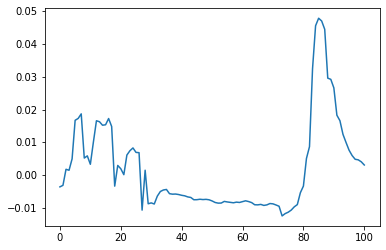

In [50]:
err_m_t = df['market_price'] - df['target_price']
plt.plot(err_m_t)

In [51]:
np.sqrt(abs(df['market_price'] - df['target_price']).mean())

0.10227358416240145

In [52]:
np.corrcoef(df['market_price'],df['eth_price'])

array([[ 1.        , -0.28072934],
       [-0.28072934,  1.        ]])

In [53]:
np.corrcoef(df['market_price'],df['target_price'])

array([[ 1.        , -0.49415185],
       [-0.49415185,  1.        ]])

In [54]:
np.corrcoef(df['market_price'],df['target_rate'])

array([[ 1.        , -0.36232777],
       [-0.36232777,  1.        ]])

In [55]:

df['market_price_rolling'] = df['market_price'].rolling(7).std()
fig = px.histogram(df, x="market_price_rolling", nbins=25)

fig.update_layout(
    title="7-Day Rolling Standard Deviation Histogram, Market Price (Controller On)",
    xaxis_title="Standard Deviation",
    yaxis_title="Frequency",
)

fig.show()

In [56]:

# std_mkt_without = res_without_controller[‘market_price’].rolling(7).std()
# std_mkt_with = res_with_controller[‘market_price’].rolling(7).std()
# df =pd.DataFrame(dict(
#     series=np.concatenate(([“With Controller”]*len(std_mkt_with), [“Without Controller”]*len(std_mkt_without))),
#     data  =np.concatenate((std_mkt_with,std_mkt_without))
# ))

# fig = df.hist(x=“data”, color=“series”, nbins=25, barmode=“overlay”,
#         labels={
#             ‘count’ : “Count”,
#             ‘data’ : “Std Dev”,
#             ‘series’ : “Simulation”
#         },
#         title=“Histogram, Standard Deviations of Market Price”)
# fig.show()